## 此專案用於開發 RUL 預測程式的最終版本, 此處先以單點分析再推廣至多工況 ##
### 此程式用於測試 多通道 高低頻項分解 的模型訓練成果 ###



### 導入模型設定與套件 ###

In [1]:
# import used functioons 
#  import tools 
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose
from tensorflow.keras.layers import Add, Concatenate,LSTM, TimeDistributed, MultiHeadAttention, LayerNormalization


from tensorflow.keras.utils import plot_model

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU devices found:")
    for gpu in gpus:
        print(gpu)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed

from rul_features.rul_data_read import read_rul_data

from test_algs.CCAE_ntu_rul import get_initial_files_datalist, CCAE_train
from test_algs.CCAE_ntu_rul import CCAE_model_application, CCAE_model_build_train

import random
np.random.seed(42)
random.seed(42)



GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 建立 LSTM 預測模型架構 ##
I2 in I2 out

### 確立訓練工況檔案來源 ###
使用 CCAE 範本作為正常工況

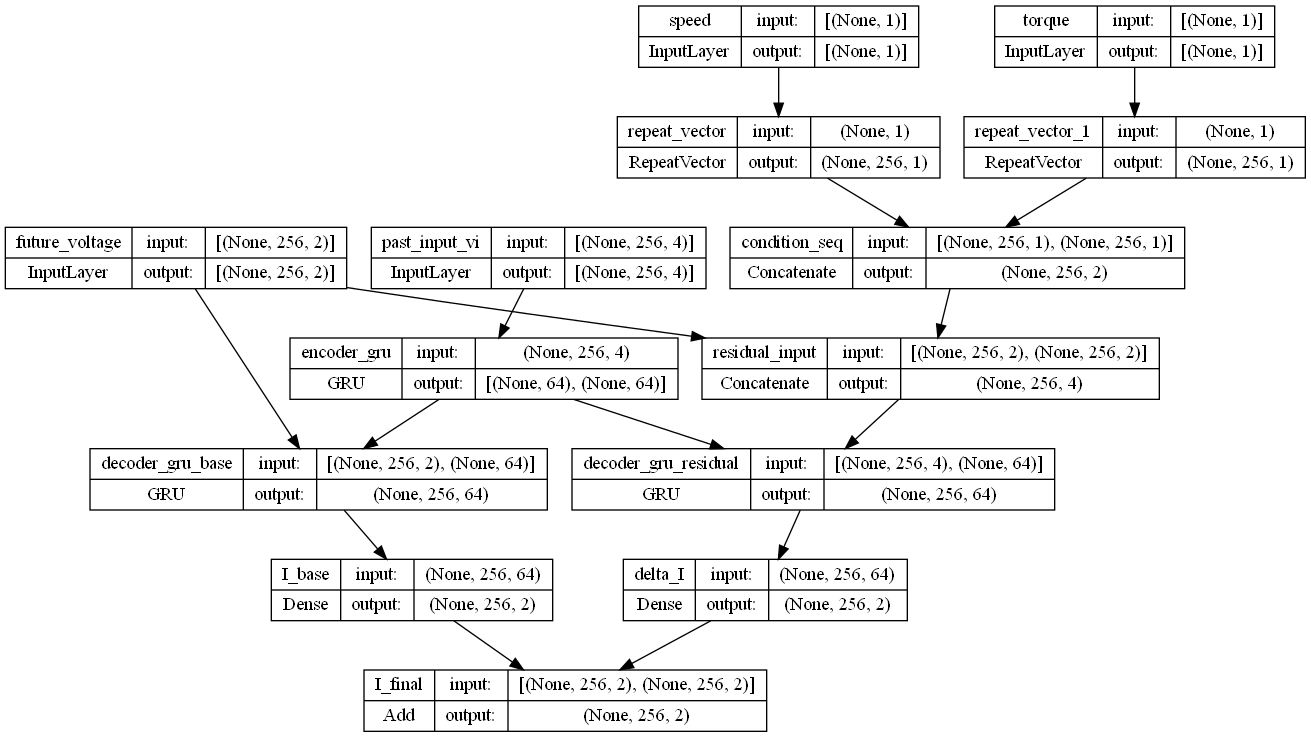

In [2]:
from datetime import datetime
import json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, Average, Add, Multiply, Lambda, GlobalAveragePooling1D, GRU
from tensorflow.keras import backend as K


def build_multiscale_lstm_fusion_model_condition(past_length=128, future_length=128, latent_dim=64):
    
    # === 輸入 ===
    past_input_vi = Input(shape=(past_length, 4), name='past_input_vi')         # V + I (共4維)
    past_current_diff_wi = Input(shape=(past_length, 2), name='past_input_wi')  # 過去電流差分（2維）
    speed = Input(shape=(1,), name='speed')                                     # 速度（1維）
    torque = Input(shape=(1,), name='torque')                                   # 扭矩（1維）
    future_voltage = Input(shape=(future_length, 2), name='future_voltage')     # 未來電壓（2維）

    # === speed, torque 展開為序列 ===
    speed_repeat = RepeatVector(past_length)(speed)       # shape: (batch_size, past_length, 1)
    torque_repeat = RepeatVector(past_length)(torque)     # shape: (batch_size, past_length, 1)

    # === 合併成完整輸入 ===
    past_input_all = Concatenate(axis=-1, name='past_input_all')([past_input_vi, past_current_diff_wi,  speed_repeat, torque_repeat])

    # === 多尺度切片（1/4、1/2、全部）===
    def slice_past(x, start_idx):
        return x[:, start_idx:, :]

    x_quarter = Lambda(lambda x: slice_past(x, past_length - past_length // 4), name="slice_quarter")(past_input_all)
    x_half    = Lambda(lambda x: slice_past(x, past_length - past_length // 2), name="slice_half")(past_input_all)
    x_all     = past_input_all

    # === 解碼分支 ===
    def decoder_branch(x_in, name):
        _, h, c = LSTM(latent_dim, return_state=True, name=f"{name}_enc")(x_in)
        x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec")(future_voltage, initial_state=[h, c])
        return Dense(2, name=f"{name}_out")(x)  # 預測未來電流

    out_64 = decoder_branch(x_quarter, "net64")
    out_96 = decoder_branch(x_half, "net96")
    out_128 = decoder_branch(x_all, "net128")
    
    # === 取 past_input_vi 中最後一個時間點的 Iα, Iβ 當作殘差來源 ===
    # past_input_vi shape: (batch, past_length, 4) → 其中最後兩維是 Iα, Iβ
    residual_current = Lambda(lambda x: x[:, -1, 2:], name="residual_current")(past_input_vi)  # shape: (batch, 2)

    # 展開為 future_length 時間序列
    residual_seq = RepeatVector(future_length, name="residual_expand")(residual_current)  # shape: (batch, future_length, 2)

    # === 三尺度融合後加殘差 ===
    output_current = Lambda(lambda x: (x[0] + x[1] + x[2]) / 3.0, name="fusion")([out_64, out_96, out_128])
    output_current = Add(name="output_with_residual")([output_current, residual_seq])

    # # === 三尺度融合 ===
    # output_current = Lambda(lambda x: (x[0] + x[1] + x[2]) / 3.0, name="fusion")([out_64, out_96, out_128])

    # === 建立模型 ===
    model = Model(
        inputs=[past_input_vi, past_current_diff_wi, speed, torque, future_voltage],
        outputs=[output_current],
        name="MSSW_LSTM_MultiTask3"
    )

    return model


def build_dual_lstm_residual_with_condition(past_length=128, future_length=128, latent_dim=32):
    # === Inputs ===
    past_input_vi = Input(shape=(past_length, 4), name='past_input_vi')           # [Vα Vβ Iα Iβ]
    future_voltage = Input(shape=(future_length, 2), name='future_voltage')       # 未來電壓
    speed = Input(shape=(1,), name='speed')                                     # scalar
    torque = Input(shape=(1,), name='torque')                                   # scalar

    # === Expand speed/torque into sequence ===
    speed_seq = RepeatVector(future_length)(speed)     # (batch, future_length, 1)
    torque_seq = RepeatVector(future_length)(torque)   # (batch, future_length, 1)
    condition_seq = Concatenate(name="condition_seq")([speed_seq, torque_seq])  # (batch, future_length, 2)

    # === Encoder ===
    _, h_enc, c_enc = LSTM(latent_dim, return_state=True, name="encoder_lstm")(past_input_vi)

    # === Stage 1: 基礎預測器（以未來電壓預測初步電流） ===
    x_base = LSTM(latent_dim, return_sequences=True, name="decoder_lstm_base")(future_voltage, initial_state=[h_enc, c_enc])
    I_base = Dense(2, name="I_base")(x_base)

    # === Stage 2: 殘差修正器（以 voltage+condition 修正預測） ===
    residual_input = Concatenate(name="residual_input")([future_voltage, condition_seq])
    x_residual = LSTM(latent_dim, return_sequences=True, name="decoder_lstm_residual")(residual_input, initial_state=[h_enc, c_enc])
    delta_I = Dense(2, name="delta_I")(x_residual)

    # === Final 預測 ===
    I_final = Add(name="I_final")([I_base, delta_I])

    # === 建立模型，雙輸出 ===
    model = Model(
        inputs=[past_input_vi, speed, torque, future_voltage],
        outputs=[I_final, I_base],  # 主預測 + 監控用
        name="DualLSTM_Residual_With_Condition"
    )
    
    return model

def build_dual_gru_residual_with_condition(past_length=128, future_length=128, latent_dim=32):
    # === Inputs ===
    past_input_vi = Input(shape=(past_length, 4), name='past_input_vi')           # [Vα Vβ Iα Iβ]
    future_voltage = Input(shape=(future_length, 2), name='future_voltage')       # 未來電壓
    speed = Input(shape=(1,), name='speed')                                       # scalar
    torque = Input(shape=(1,), name='torque')                                     # scalar

    # === Expand speed/torque into sequence ===
    speed_seq = RepeatVector(future_length)(speed)        # (batch, future_length, 1)
    torque_seq = RepeatVector(future_length)(torque)      # (batch, future_length, 1)
    condition_seq = Concatenate(name="condition_seq")([speed_seq, torque_seq])  # (batch, future_length, 2)

    # === Encoder (GRU 只回傳 h_enc) ===
    _, h_enc = GRU(latent_dim, return_state=True, name="encoder_gru")(past_input_vi)

    # === Stage 1: 基礎預測器（未來電壓 -> 預測電流） ===
    x_base = GRU(latent_dim, return_sequences=True, name="decoder_gru_base")(
        future_voltage, initial_state=[h_enc]
    )
    I_base = Dense(2, name="I_base")(x_base)

    # === Stage 2: 殘差修正器（電壓 + condition） ===
    residual_input = Concatenate(name="residual_input")([future_voltage, condition_seq])  # (batch, future_length, 4)
    x_residual = GRU(latent_dim, return_sequences=True, name="decoder_gru_residual")(
        residual_input, initial_state=[h_enc]
    )
    delta_I = Dense(2, name="delta_I")(x_residual)

    # === Final 預測 ===
    I_final = Add(name="I_final")([I_base, delta_I])

    # === 建立模型，雙輸出 ===
    model = Model(
        inputs=[past_input_vi, speed, torque, future_voltage],
        outputs=[I_final, I_base],
        name="DualGRU_Residual_With_Condition"
    )

    return model

# Initial model parameters
sequence_length=256
layer_number=1
future_length=256

model_folder_path = r'NTU_rul_models\time_series_models'
model_name = f'CCAE_direct_lstm_multiscale_hybrid_Base{sequence_length}Future{future_length}'
model_path = os.path.join(model_folder_path, model_name)
os.makedirs(model_path, exist_ok=True)


# build model 
my_model = build_dual_gru_residual_with_condition(past_length=sequence_length, future_length=future_length, latent_dim=64)
my_model.compile(
    optimizer='adam',
    loss={'I_final': 'mse', 'I_base': 'mse'},  # 可權重調整
    loss_weights={'I_final': 1.0, 'I_base': 0.2},  # 主 loss 為 I_final，I_base 僅作輔助監控
    metrics={'I_final': 'mae', 'I_base': 'mae'}
)

# my_model.compile(optimizer='adam', loss='mse')

metadata = {
    "model_name": model_name,
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

plot_model(my_model, to_file=os.path.join(model_path, model_name+'.png'), show_shapes=True, show_layer_names=True)


In [3]:

my_model.save(os.path.join(model_path, model_name + '.keras'))
        

### 資料前處理 ###

In [4]:

from sklearn.model_selection import train_test_split
from test_algs.CCAE_ntu_rul import data_augmentation
from scipy.signal import butter, filtfilt


# Data set folder 
NTU_dataset_path = r'D:\OneDrive\CCAE_experiments\CCAE_datasets'
Normal_data_path = os.path.join(NTU_dataset_path, 'Normal2')


def data_random_augmentation(raw_data, sequence_length, augmen_sample_number=1000, future_length=64):
    
    # 增加一個回傳時間步長，作為下一點訓練資料使用
    sequence_length=sequence_length+future_length  
    
    # 從 原始資料df 中隨機選取augmen_sample_number 個起始點為sequence_length長度的序列樣本。
    # raw_data 為 n,4 的序列資料，每一行分別為 voltage alpha, voltage beta, current alpha, current beta
    #資料增強倍率
    max_augment_factor = len(raw_data)-sequence_length+1
    # 最多增強樣本數不能超過資料長度除以序列長度
    augmen_sample_number = min(augmen_sample_number, max_augment_factor)


    # 初始化一個空的列表來存放提取出的樣本數據  
    samples_list = []

    # 隨機選取 augmen_sample_number 個起始點
    start_indices = np.random.choice(len(raw_data) - sequence_length + 1, augmen_sample_number, replace=False)
    samples_list = [ raw_data[start_idx:start_idx+sequence_length][:] for start_idx in start_indices]

    # 將收集到的所有樣本轉換成 NumPy 多維陣列
    final_data = np.array(samples_list)
    
    return final_data


# 列出此資料夾的所有子資料夾
Normal_subfolders = [f.path for f in os.scandir(Normal_data_path) if f.is_dir()]

selected_folder=["1800_0_5V","1800_2_0V", "1200_1_0V",  "1200_0_5V"]  # 選擇特定資料夾
# 選擇與 selected_folder 名稱符合的特定資料夾
Normal_subfolders = [folder for folder in Normal_subfolders if any(sel in folder for sel in selected_folder)]

# 分割內部測試與訓練集
train_files = []
val_files = []
for folder in Normal_subfolders:
    parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
    # 如果資料夾中有多於一個 parquet 檔案，則隨機進行分割
    
    if len(parquet_files) > 1:
        train, val = train_test_split(parquet_files, test_size=0.2)
       
        train_files.extend(train)
        val_files.extend(val)
    elif len(parquet_files) == 1:
        train_files.extend(parquet_files)

train_signals=[]
torque_array=[]
speed_array=[]
current_diff_array=[]


for file_path in train_files:
    if os.path.exists(file_path):
        
        # read the data
        df = read_rul_data(file_path)
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        
        temp_train_signals=[np.array(df["Voltage alpha downsample"]), 
                                  np.array(df["Voltage beta downsample"]),
                                  np.array(df["Current alpha downsample"]),
                                  np.array(df["Current beta downsample"])] 
                            
        torque= (df["Torque avg"]) 
        # print(df)
        speed= (df["Speed"][0])
        
        temp_train_signals = np.stack(temp_train_signals, axis=1)
        augmen_sample_number=1000  # 增強樣本數量
        temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
        # 加入 train_input_signals
        train_signals.append(temp_train_input_signals_augmented)
        torque_array.append(np.ones(augmen_sample_number) * torque)
        speed_array.append(np.ones(augmen_sample_number) * speed/3000) # rate 3000 rpm 
        
    else:
        print(f"File {file_path} does not exist.")
        
train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)
speed_array = np.concatenate(speed_array, axis=0).astype(np.float32)

# 隨機打亂訓練資料
indices = np.random.permutation(train_signals.shape[0])
train_signals = train_signals[indices]
train_input_signals = train_signals[:, :sequence_length, :]  # 取前 sequence_length 個
train_fit_signals = train_signals[:, -future_length:, :]  # 取最後 future_length 個
future_voltages=train_fit_signals[:, :, 0:2]
future_currents=train_fit_signals[:, :, 2:4]

# 對 current (第三、四維) 做一階差分，並補零使長度一致
current_diff_array = np.diff(train_input_signals[:, :, 2:4], axis=1, prepend=0)
torque_array = torque_array[indices]
speed_array=speed_array[indices]
# 將 torque_array 轉為 n, 1 batch 輸入
torque_array = torque_array.reshape(-1, 1)
speed_array = speed_array.reshape(-1, 1)
speed_current = train_input_signals[:,:,2:4] * speed_array[:, None, :]

print(f"train_input_signals shape: {train_input_signals.shape}")
print(f"train_fit_signals shape: {train_fit_signals.shape}")
print(f"torque_array shape: {torque_array.shape}")
print(f"speed_current shape: {speed_current.shape}")
print(f"current_diff_array shape: {current_diff_array.shape}")




train_input_signals shape: (60000, 256, 4)
train_fit_signals shape: (60000, 256, 4)
torque_array shape: (60000, 1)
speed_current shape: (60000, 256, 2)
current_diff_array shape: (60000, 256, 2)


(8000,)
(8000,)
Speed1 HZ, radius:  2982.23876953125, 1249.197254614672 


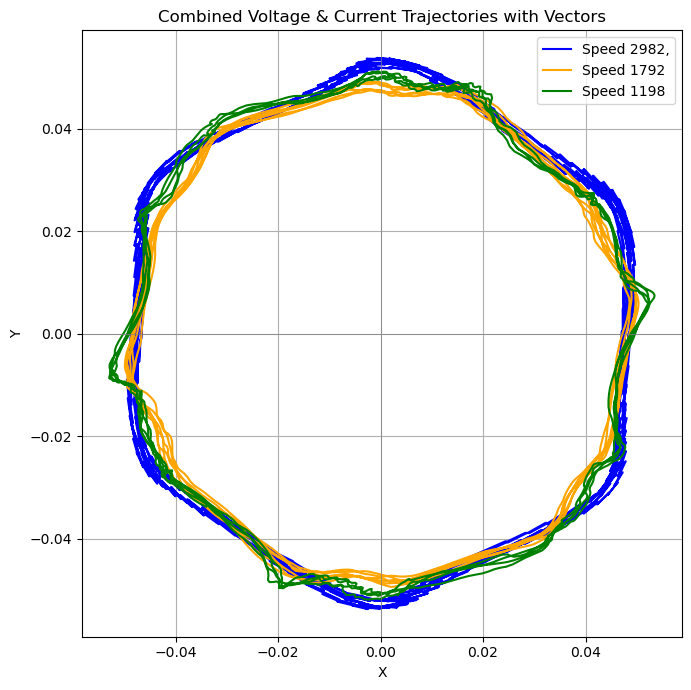

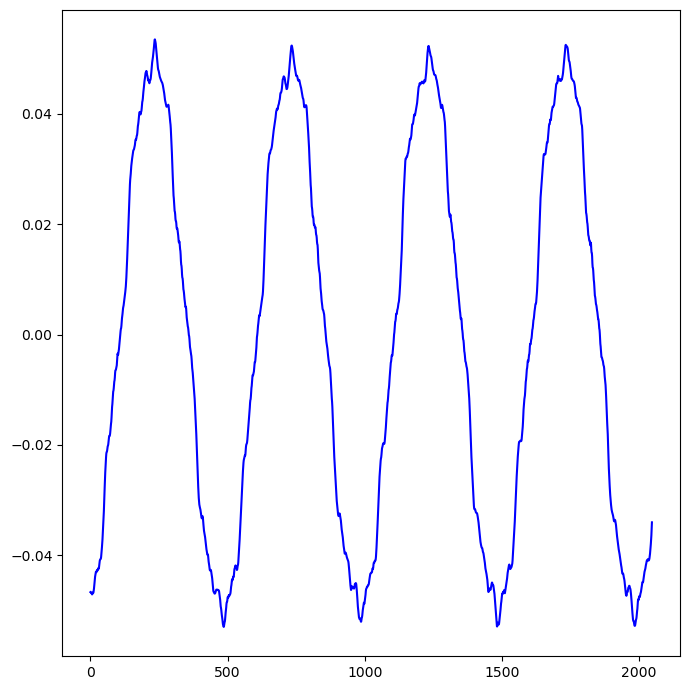

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 假設 train_input_signals 是已存在的 ndarray，形狀: (samples, time_steps, 4)

P=4 #極對數
Rs=12.5
Fs=20000

check_length = 2048
# === 載入測試資料 ===
# testfile1 = r"D:\OneDrive\CCAE_experiments\CCAE_datasets\Normal2\0611_1800_2_0V\RUL_Data_3_2.parquet"
testfile1 = r"D:\OneDrive\CCAE_experiments\CCAE_datasets\drill 2X2\0531_3000_2_0V\RUL_Data_3_2.parquet"
test_data1 = read_rul_data(testfile1)
testfile2 = r"D:\OneDrive\CCAE_experiments\CCAE_datasets\Normal2\0611_1800_1_0V\RUL_Data_3_2.parquet"
test_data2 = read_rul_data(testfile2)
testfile3 = r"D:\OneDrive\CCAE_experiments\CCAE_datasets\Normal2\0611_1200_2_0V\RUL_Data_3_2.parquet"
test_data3 = read_rul_data(testfile3)

print(test_data1["Voltage alpha"].shape)

print(test_data1["Voltage alpha downsample"].shape)

def get_vi(dta_df, check_length=512, Rs=12.5, P=4):
    voltage_xy = np.stack([
        dta_df["Voltage alpha downsample"][0:check_length],
        dta_df["Voltage beta downsample"][0:check_length]
    ], axis=1)

    current_xy = np.stack([
        dta_df["Current alpha downsample"][0:check_length],
        dta_df["Current beta downsample"][0:check_length]
    ], axis=1)
    speed_rad = dta_df["Speed"][0] / 60 * 2 * np.pi * P  # 轉換為弧度/秒
    back_emf = (voltage_xy-current_xy*Rs)/speed_rad  # 假設 Rs 為電阻值，計算反電動勢
    return voltage_xy, current_xy, back_emf, speed_rad

voltage_xy1, current_xy1, back_emf1, speed1 = get_vi(test_data1, check_length=check_length)
voltage_xy2, current_xy2, back_emf2, speed2 = get_vi(test_data2, check_length=check_length)
voltage_xy3, current_xy3, back_emf3, speed3 = get_vi(test_data3, check_length=check_length)


print(f"Speed1 HZ, radius:  {speed1/P/2/np.pi*60}, {speed1} ")

fake_angle11 = speed1* np.arange(check_length) / Fs
fake_angle12 = speed2* np.arange(check_length) / Fs
fake_angle13 = speed3* np.arange(check_length) / Fs


def to_polar_coordinates(xy):
    """將 (x, y) 座標轉換為極座標 (r, theta)"""
    r = np.sqrt(xy[:, 0]**2 + xy[:, 1]**2)
    theta = np.arctan2(xy[:, 1], xy[:, 0])
    return r, theta 

def to_mechanical_coordinates(r, angles_rad, P=4, fake_angle=[]):
    # 將 theta 角度進行累加後除以 P
    P = 4  # 假設極對數為4，請根據實際馬達極對數調整
    # unwrapped_rad = np.unwrap(angles_rad)
    unwrapped_rad = np.unwrap(angles_rad[0]+fake_angle)
    x = r * np.cos(unwrapped_rad / P)
    y = r * np.sin(unwrapped_rad / P)
    xy = np.stack([x, y], axis=1)
    return xy

back_emf1_r, back_emf1_theta = to_polar_coordinates(back_emf1)
back_emf2_r, back_emf2_theta = to_polar_coordinates(back_emf2)

# back_emf1_xy_mech = to_mechanical_coordinates(back_emf1_r, back_emf1_theta, fake_angle=fake_angle11)
# back_emf2_xy_mech = to_mechanical_coordinates(back_emf2_r, back_emf2_theta, fake_angle=fake_angle12)

# back_emf1=back_emf1_xy_mech
# back_emf2=back_emf2_xy_mech

# ===========================
# 新增：疊加圖 + 箭頭向量（使用 annotate 替代 arrow）
# ===========================

fig, ax = plt.subplots(figsize=(7, 7))

# 軌跡
ax.plot(back_emf1[:, 0], back_emf1[:, 1], label=f'Speed {test_data1["Speed"][0]:.0f},', color='blue')
ax.plot(back_emf2[:, 0], back_emf2[:, 1], label=f'Speed {test_data2["Speed"][0]:.0f}', color='orange')
ax.plot(back_emf3[:, 0], back_emf3[:, 1], label=f'Speed {test_data3["Speed"][0]:.0f}', color='green')

# 格式設定
ax.set_title("Combined Voltage & Current Trajectories with Vectors")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_aspect('equal')
ax.grid(True)
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)
ax.legend()
plt.tight_layout()
plt.show()

ig, ax = plt.subplots(figsize=(7, 7))
ax.plot(range(check_length), back_emf3[:,0], label='Current Trajectory', color='blue')
plt.tight_layout()
plt.show()

### 物理模型擬合 ###

In [143]:
# import tensorflow as tf


# # 假設成同步狀態


# # 採樣時間（20kHz）
# DT = 1 / 20000

# class MotorParamEstimator(tf.keras.Model):
#     def __init__(self, dt=DT):
#         super().__init__()
#         self.dt = dt
#         self.R = tf.Variable(12, trainable=True, dtype=tf.float32, name="R")
#         self.L = tf.Variable(0.01, trainable=True, dtype=tf.float32, name="L")
#         self.Ke = tf.Variable(0.01, trainable=True, dtype=tf.float32, name="Ke")

#     def call(self, inputs, speed):
#         V_alpha = inputs[..., 0]
#         V_beta = inputs[..., 1]
#         I_alpha = inputs[..., 2]
#         I_beta = inputs[..., 3]

#         # 數值微分
#         dI_alpha = (I_alpha[:, 1:] - I_alpha[:, :-1]) / self.dt
#         dI_beta = (I_beta[:, 1:] - I_beta[:, :-1]) / self.dt

#         # 補上第一個時間點
#         dI_alpha = tf.concat([dI_alpha[:, :1], dI_alpha], axis=1)
#         dI_beta = tf.concat([dI_beta[:, :1], dI_beta], axis=1)

#         # 展開 speed 到時間序列維度
#         speed_exp = tf.tile(speed[:, tf.newaxis, :], [1, inputs.shape[1], 1])  # shape (batch, 512, 1)

#         # 計算預測電壓
#         V_alpha_pred = self.R * I_alpha + self.L * I_beta * tf.squeeze(speed_exp, axis=-1) + self.Ke * tf.squeeze(speed_exp, axis=-1)
#         V_beta_pred = self.R * I_beta + self.L * I_alpha * tf.squeeze(speed_exp, axis=-1) # 假設 beta 軸沒有 Ke 項

#         return V_alpha_pred, V_beta_pred

# batch_size = 64

# speed_array_rad= speed_array*3000*4 * 2 * np.pi / 60  # 將速度轉換為弧度/秒

# train_dataset = tf.data.Dataset.from_tensor_slices((train_input_signals, speed_array_rad))
# train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# loss_fn = tf.keras.losses.MeanSquaredError()
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# model = MotorParamEstimator()
# # 設定是否進行 RL 擬合
# RL_fit = False  
# # RL_fit = True  

# if RL_fit:
#     for epoch in range(20):
#         epoch_loss = 0
#         for x_batch, speed_batch in train_dataset:
#             with tf.GradientTape() as tape:
#                 V_alpha_pred, V_beta_pred = model(x_batch, speed_batch)
#                 V_alpha_true = x_batch[..., 0]
#                 V_beta_true = x_batch[..., 1]
#                 loss = loss_fn(V_alpha_true, V_alpha_pred) + loss_fn(V_beta_true, V_beta_pred)
#             grads = tape.gradient(loss, model.trainable_variables)
#             optimizer.apply_gradients(zip(grads, model.trainable_variables))
#             epoch_loss += loss.numpy()
        
#         print(f"Epoch {epoch+1}, Loss: {epoch_loss:.6f}, "
#             f"R = {model.R.numpy():.6f}, L = {model.L.numpy():.6e}, Ke = {model.Ke.numpy():.6f}")

#     print("\nEstimated motor parameters:")
#     print(f"R  = {model.R.numpy():.6f} Ω")
#     print(f"L  = {model.L.numpy():.6e} H")
#     print(f"Ke = {model.Ke.numpy():.6f} V⋅s/rad")


### 模型訓練 ###

In [144]:
for name, data in zip(
    ['train_input_signals', 'speed_array', 'torque_array', 'future_voltages'],
    [train_input_signals, speed_array, torque_array, future_voltages]
):
    print(f"{name}: type={type(data)}, shape={getattr(data, 'shape', 'N/A')}, dtype={getattr(data, 'dtype', 'N/A')}")



train_input_signals: type=<class 'numpy.ndarray'>, shape=(60000, 256, 4), dtype=float32
speed_array: type=<class 'numpy.ndarray'>, shape=(60000, 1), dtype=float32
torque_array: type=<class 'numpy.ndarray'>, shape=(60000, 1), dtype=float32
future_voltages: type=<class 'numpy.ndarray'>, shape=(60000, 256, 2), dtype=float32


1/1 [==============================] - 0s 427ms/step
Epoch 1/10
844/844 [==============================] - 30s 33ms/step - loss: 0.0278 - I_final_loss: 0.0196 - I_base_loss: 0.0413 - I_final_mae: 0.0758 - I_base_mae: 0.1218 - val_loss: 0.0033 - val_I_final_loss: 0.0021 - val_I_base_loss: 0.0059 - val_I_final_mae: 0.0361 - val_I_base_mae: 0.0614
Epoch 2/10
844/844 [==============================] - 27s 32ms/step - loss: 0.0019 - I_final_loss: 0.0012 - I_base_loss: 0.0035 - I_final_mae: 0.0273 - I_base_mae: 0.0465 - val_loss: 0.0012 - val_I_final_loss: 8.2244e-04 - val_I_base_loss: 0.0021 - val_I_final_mae: 0.0225 - val_I_base_mae: 0.0362
Epoch 3/10
844/844 [==============================] - 27s 32ms/step - loss: 0.0011 - I_final_loss: 7.4688e-04 - I_base_loss: 0.0017 - I_final_mae: 0.0215 - I_base_mae: 0.0321 - val_loss: 0.0012 - val_I_final_loss: 8.6938e-04 - val_I_base_loss: 0.0014 - val_I_final_mae: 0.0237 - val_I_base_mae: 0.0298
Epoch 4/10
844/844 [==============================] -

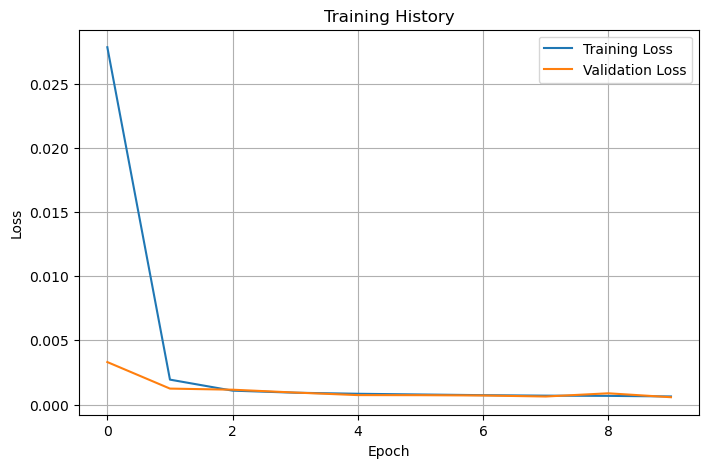

In [145]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        
        
my_model.predict([train_input_signals[:1], speed_array[:1], torque_array[:1], future_voltages[:1]])
history = my_model.fit(
     x=[train_input_signals, speed_array, torque_array, future_voltages],
    y={'I_final': future_currents, 'I_base': future_currents},
    batch_size=64,
    epochs=10,
    validation_split=0.1
)

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

In [156]:
print(f"Train input signals shape: {train_input_signals.shape}")
# print(x_128.shape)
# === 載入測試資料 ===

testfile=r"D:\OneDrive\CCAE_experiments\CCAE_datasets\Normal2\0611_1200_2_0V\RUL_Data_3_2.parquet"
test_data = read_rul_data(testfile)
start_idx=112

# test_data = read_rul_data(val_files[0])  # 使用第一個驗證檔案進行測試


Train input signals shape: (60000, 256, 4)


### 驗證結果 ###

past_vi shape: (1, 256, 4)
speed_current_past shape: (1, 256, 2)
x_future shape: (1, 256, 2)
speed shape: ()
torque shape: ()
past_current shape: (256, 2)
current_diff_past shape: (1, 256, 2)
1/1 [==============================] - 0s 57ms/step
(1, 256, 2)


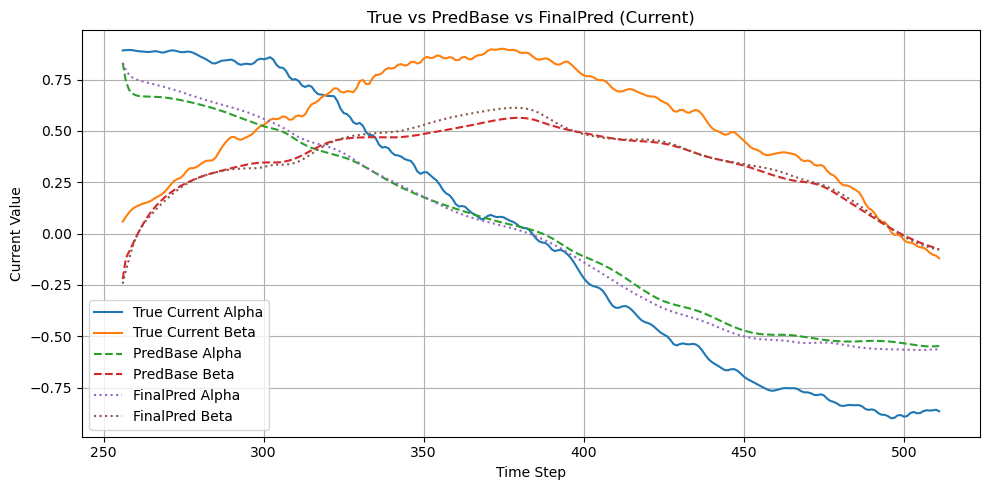

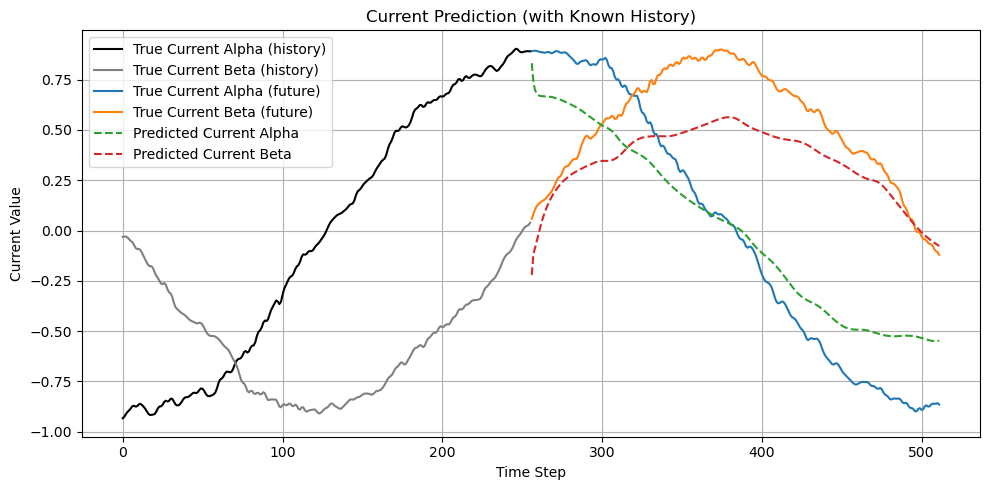

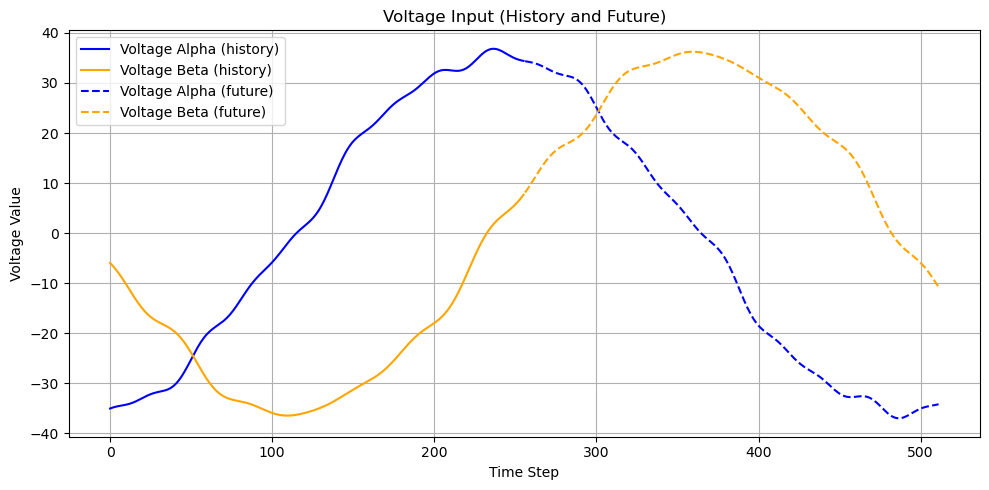

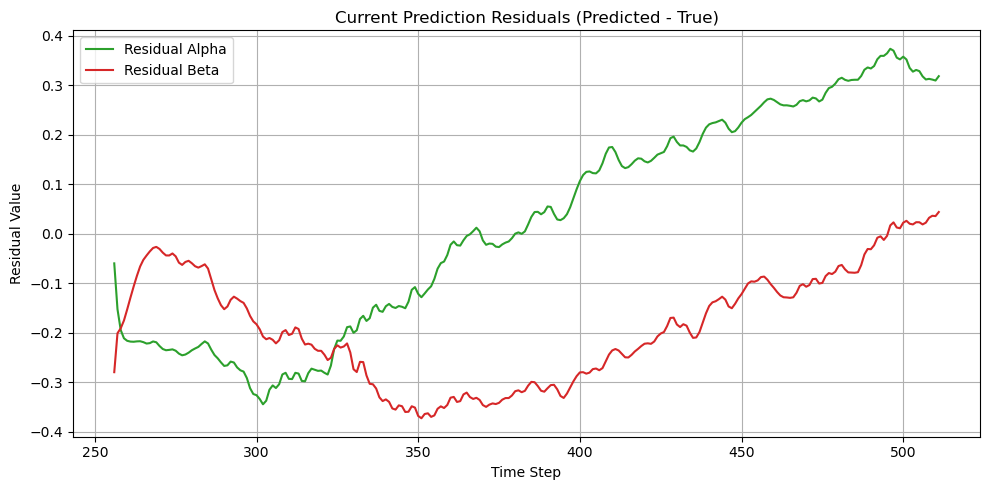

In [157]:

import numpy as np
import matplotlib.pyplot as plt

def direct_forecast(model, past_voltage, past_current, future_voltage):
    """
    For MSSW_LSTM_AutoSplit version (accepts [past_vi_all, future_voltage])
    """
    past_vi_all = np.concatenate([past_voltage, past_current], axis=1)  # shape: (128, 4)
    past_vi_all = np.expand_dims(past_vi_all, axis=0).astype(np.float32)  # (1, 128, 4)
    future_voltage = np.expand_dims(future_voltage, axis=0).astype(np.float32)  # (1, 128, 2)

    pred_current, pred_torque, pred_speed = model.predict([past_vi_all, future_voltage], verbose=0)
    return pred_current, pred_torque, pred_speed  # 去掉 batch 維度

# V/I歷史輸入與未來電壓
past_vi = np.stack([
    test_data["Voltage alpha downsample"][:sequence_length],
    test_data["Voltage beta downsample"][:sequence_length],
    test_data["Current alpha downsample"][:sequence_length],
    test_data["Current beta downsample"][:sequence_length]
], axis=1)  # shape (128, 4)
past_vi=np.expand_dims(past_vi, axis=0).astype(np.float32)


speed_current_past = np.stack([
    test_data["Current alpha downsample"][:sequence_length]* test_data["Speed"][0]/3000,   
    test_data["Current beta downsample"][:sequence_length]* test_data["Speed"][0]/3000
], axis=1)  # shape (128, 2)
speed_current_past = np.expand_dims(speed_current_past, axis=0).astype(np.float32)  # (1, 128, 2)



current_diff_past = np.diff(past_vi[0, :, 2:4], axis=1, prepend=0)
current_diff_past = np.expand_dims(current_diff_past, axis=0).astype(np.float32)  # (1, 128, 2)

x_future = np.stack([
    test_data["Voltage alpha downsample"][sequence_length:sequence_length+future_length],
    test_data["Voltage beta downsample"][sequence_length:sequence_length+future_length]
], axis=1)
x_future=np.expand_dims(x_future, axis=0).astype(np.float32)  # (1, 128, 2)

true_future_current = np.stack([
    test_data["Current alpha downsample"][sequence_length:sequence_length+future_length],
    test_data["Current beta downsample"][sequence_length:sequence_length+future_length]
], axis=1)

speed= (test_data["Speed"][0]/3000).astype(np.float32)
torque= (test_data["Torque avg"]).astype(np.float32)

past_voltage = past_vi[0, :, 0:2]
past_current = past_vi[0, :, 2:4]


# 確認資料形狀
# 印出輸入變數名稱與形狀
print(f"past_vi shape: {past_vi.shape}")
print(f"speed_current_past shape: {speed_current_past.shape}")
print(f"x_future shape: {x_future.shape}")
print(f"speed shape: {speed.shape}")
print(f"torque shape: {torque.shape}")
print(f"past_current shape: {past_current.shape}")
print(f"current_diff_past shape: {current_diff_past.shape}")



# === 預測 ===
future_pred, pred_base  = my_model.predict([
    past_vi, 
    np.array([[speed]]), 
    np.array([[torque]]), 
    x_future
])


# y_future_pred=future_pred
y_future_pred=pred_base
print(y_future_pred.shape)  # 應該是 (1, future_length, 2)

plt.figure(figsize=(10, 5))
# 在同一張圖上畫 true_future_current, pred_base, y_future_pred
plt.plot(range(sequence_length, sequence_length+future_length), true_future_current[:, 0], label='True Current Alpha')
plt.plot(range(sequence_length, sequence_length+future_length), true_future_current[:, 1], label='True Current Beta')
plt.plot(range(sequence_length, sequence_length+future_length), pred_base[0, :, 0], label='PredBase Alpha', linestyle='--')
plt.plot(range(sequence_length, sequence_length+future_length), pred_base[0, :, 1], label='PredBase Beta', linestyle='--')
plt.plot(range(sequence_length, sequence_length+future_length), future_pred[0, :, 0], label='FinalPred Alpha', linestyle=':')
plt.plot(range(sequence_length, sequence_length+future_length), future_pred[0, :, 1], label='FinalPred Beta', linestyle=':')
plt.title('True vs PredBase vs FinalPred (Current)')
plt.xlabel('Time Step')
plt.ylabel('Current Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 繪圖：歷史 + 未來預測 ===
plt.figure(figsize=(10, 5))
plt.plot(range(sequence_length), past_current[:, 0], color='black', label='True Current Alpha (history)')
plt.plot(range(sequence_length), past_current[:, 1], color='gray', label='True Current Beta (history)')

plt.plot(range(sequence_length, sequence_length+future_length), true_future_current[:, 0], color='tab:blue', label='True Current Alpha (future)')
plt.plot(range(sequence_length, sequence_length+future_length), true_future_current[:, 1], color='tab:orange', label='True Current Beta (future)')
plt.plot(range(sequence_length, sequence_length+future_length), y_future_pred[0, :, 0], color='tab:green', linestyle='--', label='Predicted Current Alpha')
plt.plot(range(sequence_length, sequence_length+future_length), y_future_pred[0, :, 1], color='tab:red', linestyle='--', label='Predicted Current Beta')
plt.title('Current Prediction (with Known History)')
plt.xlabel('Time Step')
plt.ylabel('Current Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === 繪圖：電壓輸入 ===
plt.figure(figsize=(10, 5))
plt.plot(range(sequence_length), past_voltage[:, 0], color='blue', label='Voltage Alpha (history)')
plt.plot(range(sequence_length), past_voltage[:, 1], color='orange', label='Voltage Beta (history)')
plt.plot(range(sequence_length, sequence_length+future_length), x_future[0][:, 0], color='blue', linestyle='--', label='Voltage Alpha (future)')
plt.plot(range(sequence_length, sequence_length+future_length), x_future[0][:, 1], color='orange', linestyle='--', label='Voltage Beta (future)')
plt.title('Voltage Input (History and Future)')
plt.xlabel('Time Step')
plt.ylabel('Voltage Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === 繪圖：預測誤差 ===

plt.figure(figsize=(10, 5))
residuals = y_future_pred[0] - true_future_current
plt.plot(range(sequence_length, sequence_length+future_length), residuals[:, 0], color='tab:green', label='Residual Alpha')
plt.plot(range(sequence_length, sequence_length+future_length), residuals[:, 1], color='tab:red', label='Residual Beta')
plt.title('Current Prediction Residuals (Predicted - True)')
plt.xlabel('Time Step')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [173]:
def build_baseline_gru_seq2seq(past_length=128, future_length=128, latent_dim=32):
    # === Input: 過去的 Vα, Vβ, Iα, Iβ ===
    past_input_vi = Input(shape=(past_length, 2), name='past_input_vi')  # e.g. (128, 4)

    # === Encoder ===
    _, h_enc = GRU(latent_dim, return_state=True, name="encoder_gru")(past_input_vi)

    # === Decoder ===
    decoder_input = RepeatVector(future_length, name="repeat_context")(h_enc)  # shape: (batch, future_length, latent_dim)
    x = GRU(latent_dim, return_sequences=True, name="decoder_gru")(decoder_input, initial_state=[h_enc])

    # === 輸出未來電流 Iα Iβ ===
    I_future = Dense(2, name="I_future")(x)

    model = Model(
        inputs=past_input_vi,
        outputs=I_future,
        name="Baseline_GRU_Seq2Seq"
    )

    return model

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        
current_model = build_baseline_gru_seq2seq(past_length=sequence_length, future_length=future_length, latent_dim=16)
current_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print(train_input_signals.shape)
print("X shape:", train_input_signals[:, :, 2:4].shape)
print("Y shape:", future_currents.shape)
print("X dtype:", train_input_signals.dtype)
print("Y dtype:", future_currents.dtype)


print(future_currents.shape)
current_model.predict([train_input_signals[0, :, 2:4]])
# current_model.fit(
#     x=train_input_signals[:,:,2:4],  # 只使用 Iα, Iβ 作為輸入
#     y=future_currents,
#     batch_size=8,
#     epochs=10,
#     validation_split=0.1
# )

ResourceExhaustedError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Sub]